In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
# from sklearn.model_selection import train_test_split
import pickle
from scipy.ndimage.measurements import label
%matplotlib inline

In [2]:
#PARAMETERS.

#These MUST be the same as how we trained the classifier  in P5_Extract_Features_Train_SVC.ipynb
# color_space = 'RGB' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
# orient = 9  # HOG orientations
# pix_per_cell = 8 # HOG pixels per cell
# cell_per_block = 2 # HOG cells per block
# hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
# spatial_size = (16, 16) # Spatial binning dimensions
# hist_bins = 24   # Number of histogram bins
# spatial_feat = True # Spatial features on or off
# hist_feat = True # Histogram features on or off
# hog_feat = True # HOG features on or off


# y_start_stop = [400, 720] # Min and max in y to search in slide_window()

In [20]:
#import the SCV and Parameters from P5_Extract_Features_Train_SVC File

svc,X_scaler,settings = pickle.load( open( "trainedYUV32-32-32-A16svc.p", "rb" ) )
#I confirmed that loading an SVC from a pickle file works by reloading all the images, extracting features and testing
#Then I deleted all those cells after confirming
color_space = settings[0]
orient = settings[1]
pix_per_cell = settings[2]
cell_per_block = settings[3]
hog_channel = settings[4]
spatial_size = settings[5]
hist_bins = settings[6]
spatial_feat = settings[7]
hist_feat = settings[8]
hog_feat =  settings[9]

print("color_space: ",color_space)
print("orient: ",orient)
print("pix_per_cell: ", pix_per_cell)
print("cell_per_block: ", cell_per_block)
print("hog_channel: ", hog_channel)
print("spatial_size: ", spatial_size)
print("hist_bins: ", hist_bins)
print("spatial_feat: ", spatial_feat)
print("hist_feat: ", hist_feat)
print("hog_feat: ", hog_feat)

color_space:  YUV
orient:  9
pix_per_cell:  16
cell_per_block:  2
hog_channel:  ALL
spatial_size:  (32, 32)
hist_bins:  32
spatial_feat:  True
hist_feat:  True
hog_feat:  True


In [21]:
##Extract Feastures Functions

def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256), orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        else: feature_image = np.copy(image)      
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        # Apply color_hist() also with a color space option now
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        
        # Append the new feature vector to the features list
        features.append(np.concatenate((spatial_features, hist_features,hog_features)))
    # Return list of feature vectors
    return features

def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

In [22]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy
    
    
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_windows = np.int(xspan/nx_pix_per_step) - 1
    ny_windows = np.int(yspan/ny_pix_per_step) - 1
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

In [23]:
# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
#         win = (window[0][1],window[1][1], window[0][0],window[1][0])
        #3) Extract the test window from original image - resize it to 64x64
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

In [24]:
image = mpimg.imread('test_images/rtest0.png')
draw_image = np.copy(image)
image = image.astype(np.float32)/255.0

In [25]:
windows = []

#Windows1
y_start_stop1 = [380, 580]
x_start_stop1 = [200,1200] 
win_size1 = (96,96)
windows.extend(slide_window(image, x_start_stop=x_start_stop1, y_start_stop=y_start_stop1, 
                    xy_window=win_size1, xy_overlap=(0.65, 0.65)))

# # Windows2
y_start_stop2 = [400,592]
x_start_stop2 = [0,1280]
win_size2 = (140,140)
windows.extend(slide_window(image, x_start_stop=x_start_stop2, y_start_stop=y_start_stop2, 
                    xy_window=win_size2, xy_overlap=(0.55, 0.55)))

# Windows3
y_start_stop3 = [410,680]
x_start_stop3 = [0,1280] 
win_size3 = (192,192)
windows.extend(slide_window(image, x_start_stop=x_start_stop3, y_start_stop=y_start_stop3, 
                    xy_window=win_size3, xy_overlap=(0.55, 0.55)))

# Windows4
y_start_stop4 = [380,508]
x_start_stop4 = [300,1200] 
win_size4 = (64,64)
windows.extend(slide_window(image, x_start_stop=x_start_stop4, y_start_stop=y_start_stop4, 
                    xy_window=win_size4, xy_overlap=(0.6, 0.6)))


349


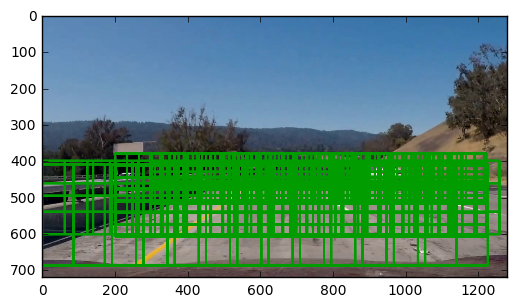

In [26]:
window_img = draw_boxes(draw_image, windows, color=(0, 100, 0), thick=6)
plt.imshow(window_img)
print (len(windows))

In [27]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    car_colors = [(0,0,255),(0,255,0),(255,0,0),(0,100,200),(200,100,0),(200,0,100),(100,100,100)]
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        if check_box(bbox)== True:
            cv2.rectangle(img, bbox[0], bbox[1], car_colors[(car_number-1)%5], 5)
    # Return the image
    return img


def check_box(bbox):
    min_size = 64
    if (bbox[1][0] - bbox [0][0]) >= min_size and (bbox[1][1] - bbox [0][1]) >= min_size:
        return True
    else:
        return False

class heatmap_obj:
    def __init__(self,image,num_frames):
        self.heatmap = np.zeros_like(image[:,:,0])
        self.iteration = 0
        self.heatmaps = []
        self.cur_heatmap = np.zeros_like(image[:,:,0])
        self.threshmap = np.zeros_like(image[:,:,0])
        self.num_history = num_frames
        
    def add_heat(self, bbox_list):
        # Iterate through list of bboxes
        self.iteration += 1
        self.cur_heatmap = np.zeros_like(image[:,:,0])
        for box in bbox_list:
            # Add += 1 for all pixels inside each bbox
            # Assuming each "box" takes the form ((x1, y1), (x2, y2))
#             self.cur_heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
            self.cur_heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] = 1
            
        # Return updated heatmap
        self.update_hms()
        return None
    
    def apply_threshold(self, threshold):
        # Zero out pixels below the threshold
        self.threshmap = np.copy(self.heatmap)
        self.threshmap[self.heatmap <= threshold] = 0
        # Return thresholded map
        return None
    
    def update_hms(self):
#         num_history = 36
        self.heatmaps.append(self.cur_heatmap)
        if len(self.heatmaps) > self.num_history:
            self.heatmaps.pop(0)
        self.heatmap = sum(self.heatmaps)
            

In [28]:
# image = mpimg.imread('test_images/rtest0.png')
image = mpimg.imread('test_images/test6.jpg')
draw_image = np.copy(image)
image = image.astype(np.float32)/255.0

# draw_img = p5(image)
# plt.imshow(draw_img)

In [33]:

hmt = heatmap_obj(image,36)


YUV


/home/robbie/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:23: RuntimeWarning: divide by zero encountered in true_divide
/home/robbie/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:23: RuntimeWarning: invalid value encountered in multiply


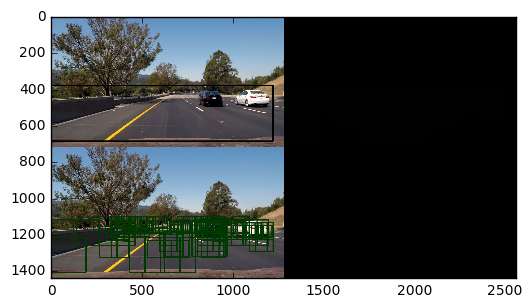

In [34]:
image = mpimg.imread('test_images/test6.jpg')
draw_image = np.copy(image)
image = image.astype(np.float32)/255.0
print (color_space)

hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

window_img = draw_boxes(image, hot_windows, color=(0, 200, 0), thick=6)

hmt.add_heat(hot_windows)
hmt.apply_threshold(2)
labels = label(hmt.heatmap)

draw_img = draw_labeled_bboxes(np.copy(image), labels)

heatmap = hmt.heatmap*(255.0/hmt.heatmap.max())
heatmap_out = np.dstack((heatmap,heatmap,heatmap))
threshmap = hmt.threshmap*(255.0/hmt.threshmap.max())
threshmap_out = np.dstack((threshmap,threshmap,threshmap))


plt.imshow(np.concatenate((np.concatenate((draw_img,heatmap_out),axis=1),np.concatenate((window_img,threshmap_out),axis=1))
                          ,axis=0))


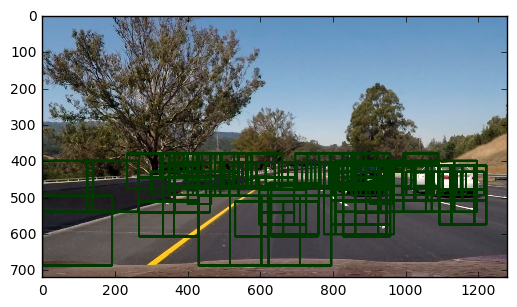

In [31]:
plt.imshow(window_img)

In [35]:


threshold_detections = 30
num_frames = 36
hm = heatmap_obj(np.zeros_like(image),num_frames)
def p5(image):
    draw_image = np.copy(image)
    image = image.astype(np.float32)/255.0
    hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)                       
    
    # window_img = draw_boxes(draw_image, windows, color=(0, 100, 200), thick=6)
    window_img = draw_boxes(draw_image, hot_windows, color=(0, 180, 200), thick=6)
    hm.add_heat(hot_windows)
    hm.apply_threshold(threshold_detections)
    labels = label(hm.threshmap)
    #draw the labelled boxes on the image
    draw_img = draw_labeled_bboxes(draw_image, labels)
    
    #scale the current heatmap and make it RGB colorspace compatible
    heatmap = hm.heatmap*(255.0/hm.heatmap.max())
    heatmap_out = np.dstack((heatmap,heatmap,heatmap))
    
    #scale the current thresholded heatmap and make it RGB colorspace compatible
    threshmap = hm.threshmap*(255.0/hm.threshmap.max())
    threshmap_out = np.dstack((threshmap,threshmap,threshmap))
    
    #return 
    return (np.concatenate((np.concatenate((draw_img,heatmap_out),axis=1),np.concatenate((window_img,threshmap_out),axis=1))
                          ,axis=0))

/home/robbie/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:29: RuntimeWarning: divide by zero encountered in true_divide
/home/robbie/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:29: RuntimeWarning: invalid value encountered in multiply


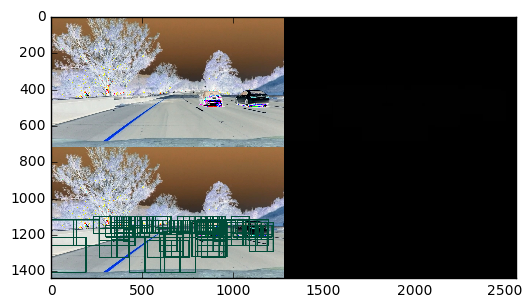

In [36]:
image = mpimg.imread('test_images/test6.jpg')
out = p5(image)
plt.imshow(out)

In [17]:
from moviepy.editor import VideoFileClip

/home/robbie/anaconda3/lib/python3.5/site-packages/skimage/filter/__init__.py:6: skimage_deprecation: The `skimage.filter` module has been renamed to `skimage.filters`.  This placeholder module will be removed in v0.13.
  warn(skimage_deprecation('The `skimage.filter` module has been renamed '


In [42]:
proj5_output = 'proj5s.mp4'
driving_clip = VideoFileClip('project_short.mp4')
out_clip = driving_clip.fl_image(p5)
%time out_clip.write_videofile(proj5_output, audio=False)

/home/robbie/anaconda3/lib/python3.5/site-packages/moviepy/audio/io/readers.py:110: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.nchannels))



MoviePy: building video file proj5s.mp4
----------------------------------------

Writing video into proj5s.mp4
|----------| 0/361   0% [elapsed: 00:00 left: ?, ? iters/sec]

/home/robbie/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:24: RuntimeWarning: divide by zero encountered in true_divide
/home/robbie/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:24: RuntimeWarning: invalid value encountered in multiply


|----------| 1/361   0% [elapsed: 00:00 left: 04:41,  1.28 iters/sec]

/home/robbie/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:24: RuntimeWarning: divide by zero encountered in true_divide
/home/robbie/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:24: RuntimeWarning: invalid value encountered in multiply


Done writing video in proj5s.mp4 !
Your video is ready !
CPU times: user 4min 47s, sys: 6.49 s, total: 4min 54s
Wall time: 4min 57s


In [18]:
proj5_output = 'proj5xYUV.mp4'
driving_clip = VideoFileClip('project_video.mp4')
out_clip = driving_clip.fl_image(p5)
%time out_clip.write_videofile(proj5_output, audio=False)

/home/robbie/anaconda3/lib/python3.5/site-packages/moviepy/audio/io/readers.py:110: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.nchannels))



MoviePy: building video file proj5xYUV.mp4
----------------------------------------

Writing video into proj5xYUV.mp4
|----------| 0/1210   0% [elapsed: 00:00 left: ?, ? iters/sec]

/home/robbie/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:24: RuntimeWarning: divide by zero encountered in true_divide
/home/robbie/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:24: RuntimeWarning: invalid value encountered in multiply


|----------| 1/1210   0% [elapsed: 00:00 left: 18:20,  1.10 iters/sec]

/home/robbie/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:24: RuntimeWarning: divide by zero encountered in true_divide
/home/robbie/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:24: RuntimeWarning: invalid value encountered in multiply


Done writing video in proj5xYUV.mp4 !
Your video is ready !
CPU times: user 16min 38s, sys: 29.3 s, total: 17min 7s
Wall time: 17min 25s
